# CABLSTM 비교분석 report

In [24]:
from keras.src.preprocessing.sequence import TimeseriesGenerator
import numpy as np
data = np.array([[i] for i in range(1000)])
targets = np.random.randint(0,2,1000)
data_gen = TimeseriesGenerator(data, targets,
                               length=10,batch_size=2)

In [25]:
data_gen[0][1]

array([1, 1])

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.signal import hilbert, chirp
from scipy.signal import butter,lfilter
from datetime import datetime
import seaborn as sns
import sklearn.model_selection
import sklearn.metrics
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Flatten
from keras.layers import LSTM, Dense, Activation, Bidirectional
#from keras_self_attenotin import SeqSelfAttention
from keras import optimizers
from keras.layers import Layer
from keras import backend as K
from numpy import quantile, where, random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy
import tensorflow as tf

1. 데이터 로드 및 split

In [2]:
import pandas as pd
label_62 = pd.read_csv('./label/label_62.csv')
label_66 = pd.read_csv('./label/label_66.csv')
total = pd.concat([label_62,label_66],axis=0)
del label_62
del label_66
total.interpolate('linear',inplace = True)


In [3]:
def X_y_split(df:pd.DataFrame):
  selected = ['Apparent_Power_Va3','Line_Voltage_V12','x','y','z','Derived Variable']
  y_feature = ['label']
  X = df[selected]
  y = df[y_feature]
  return X ,y

In [4]:
from sklearn.preprocessing import MinMaxScaler
def scale_data_except_time_column(x_train, x_val,x_test):
    """
    Scale data using MinMaxScaler, excluding the 'time' column.

    Parameters:
    x_train (pd.DataFrame): Training data
    x_test (pd.DataFrame): Testing data

    Returns:
    pd.DataFrame: Scaled training data
    pd.DataFrame: Scaled testing data
    """
    scaler = MinMaxScaler()

    # Identifying the 'time' column in the datasets
    time_train = x_train['time'].copy() if 'time' in x_train.columns else None
    time_val = x_val['time'].copy() if 'time' in x_val.columns else None
    time_test = x_test['time'].copy() if 'time' in x_test.columns else None

    # Dropping the 'time' column for scaling
    x_train_scaled = x_train.drop(columns=['time'], errors='ignore')
    x_val_scaled = x_val.drop(columns=['time'], errors='ignore')
    x_test_scaled = x_test.drop(columns=['time'], errors='ignore')

    # Fitting and transforming the training data
    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_scaled), columns=x_train_scaled.columns, index=x_train_scaled.index)

    # Transforming the testing data
    x_val_scaled = pd.DataFrame(scaler.fit_transform(x_val_scaled), columns=x_val_scaled.columns, index=x_val_scaled.index)    
    x_test_scaled = pd.DataFrame(scaler.transform(x_test_scaled), columns=x_test_scaled.columns, index=x_test_scaled.index)

    # Adding the 'time' column back to the datasets
    if time_train is not None:
        x_train_scaled['time'] = time_train
    if time_val is not None:
        x_val_scaled['time'] = time_val        
    if time_test is not None:
        x_test_scaled['time'] = time_test

    return x_train_scaled, x_val_scaled,x_test_scaled

In [5]:
import numpy as np
from typing import Iterator, Tuple

def gen_over(X: np.ndarray, Y: np.ndarray, window_size: int, normal_step: int, small_step: int, batch_size: int) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    indices = np.arange(len(Y))
    
    while True:  # 무한 반복
        X_batch = []
        Y_batch = []

        for _ in range(batch_size):
            # 이상 데이터 선택 확률을 높임
            if np.random.rand() < 0.1:  # 정상 데이터 선택 확률
                index = np.random.choice(indices[window_size - 1:len(Y) - window_size: normal_step])
            else:  # 이상 데이터 선택 확률
                anomaly_indices = np.where(Y.flatten() == 1)[0]
                valid_indices = [idx for idx in anomaly_indices if idx >= window_size - 1]
                index = np.random.choice(valid_indices[::small_step])

            # 윈도우 범위 조정
            start_idx = max(index - window_size + 1, 0)
            end_idx = index + 1

            # X, Y 배치에 추가
            X_batch.append(X[start_idx:end_idx])
            Y_batch.append(Y[index])

        yield np.array(X_batch), np.array(Y_batch)

# 예시 데이터 생성
np.random.seed(0)  # 결과의 일관성을 위해 시드 설정
X = np.random.rand(1000, 5)  # 1000개의 샘플, 각 샘플은 5개의 특성을 가짐
Y = np.zeros(1000)  # 대부분의 샘플은 정상
Y[np.random.choice(1000, 100, replace=False)] = 1  # 약 10%의 샘플을 이상으로 설정

# 제너레이터 매개변수 설정
window_size = 10
normal_step = 10
small_step = 2
batch_size = 32

# 데이터 제너레이터 생성
anomaly_data_gen = gen_over(X, Y, window_size, normal_step, small_step, batch_size)

# 제너레이터에서 첫 번째 배치 추출 및 출력 (테스트용)
first_batch_X, first_batch_Y = next(anomaly_data_gen)
first_batch_X.shape, first_batch_Y.shape, first_batch_Y[:10]  # 첫 10개의 레이블 확인

((32, 10, 5), (32,), array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]))

In [13]:
def df_to_numpy(X:pd.DataFrame, y:pd.DataFrame):
    '''
    여기서 dataframe을 astype으로 float 변환 및 .values으로 numpy로 변환
    return X,y
    '''
    X = X.astype('float').values
    y = y.astype('float').values
    return X,y

In [14]:
df = pd.DataFrame()
df['time'] = pd.to_datetime(total['time'])

In [15]:
df['time'].diff().value_counts() , total.isnull().sum().sum()

(time
 0 days 00:00:01    674318
 0 days 00:00:02         8
 0 days 00:00:11         1
 2 days 00:02:01         1
 Name: count, dtype: int64,
 0)

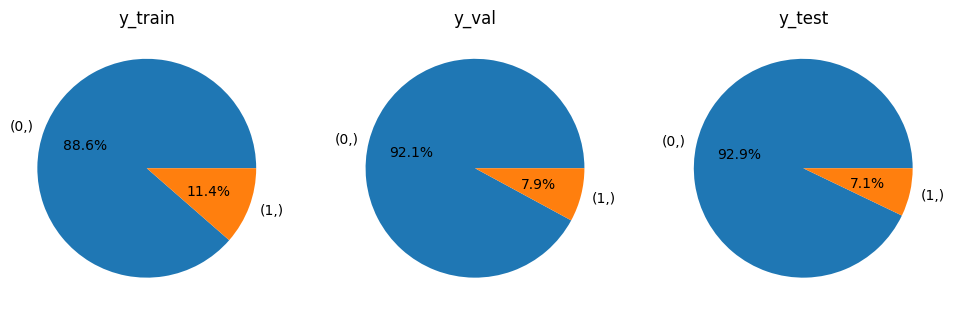

In [17]:
X , y = X_y_split(total)
selected_feature = ['Apparent_Power_Va3', 'Line_Voltage_V12','y']
X=X[selected_feature]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,shuffle=False)
train_value_counts = y_train.value_counts()
test_value_counts = y_test.value_counts()
val_value_counts = y_val.value_counts()

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].pie(train_value_counts, labels=train_value_counts.index, autopct='%1.1f%%')
ax[0].set_title('y_train')

ax[1].pie(val_value_counts, labels=test_value_counts.index, autopct='%1.1f%%')
ax[1].set_title('y_val')

ax[2].pie(test_value_counts, labels=test_value_counts.index, autopct='%1.1f%%')
ax[2].set_title('y_test')

plt.show()

In [20]:
len(x_train), len(generator_train.targets)

(546206, 546206)

In [18]:
#step
step = 120

In [19]:
X , y = X_y_split(total)
X=X[selected_feature]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,shuffle=False)

x_train, x_val, x_test = scale_data_except_time_column(x_train,x_val,x_test)

x_train , y_train = df_to_numpy(x_train,y_train)
x_val , y_val = df_to_numpy(x_val,y_val)
x_test , y_test = df_to_numpy(x_test,y_test)

from keras.preprocessing.sequence import TimeseriesGenerator

generator_train = TimeseriesGenerator(x_train, y_train, length=step,batch_size=64)
generator_val = TimeseriesGenerator(x_val, y_val, length=step,batch_size=1)
generator_test = TimeseriesGenerator(x_test, y_test, length=step,batch_size=1)

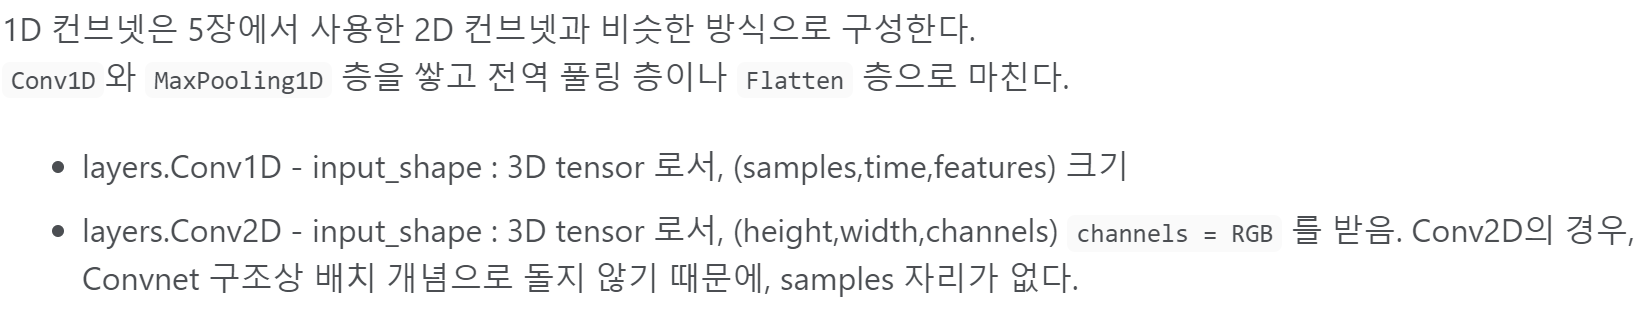

In [182]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 정밀도 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # 재현율 계산
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 점수 계산
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val


### 1. 데이터 로드

In [183]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# 모델 구조 정의
X_input = Input(shape=(step, len(selected_feature)))
x = Conv1D(64,3, activation='relu')(X_input)
x= MaxPooling1D()(x)
x = Conv1D(64,3, activation='relu')(X_input)
x= MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(128,activation = 'relu')(x)
y_output = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 sigmoid 활성화 함수

# 모델 컴파일
cnn = Model(X_input, y_output)
opt = Adam(learning_rate=0.1)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

In [184]:
cnn.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 120, 3)]          0         
                                                                 
 conv1d_33 (Conv1D)          (None, 118, 64)           640       
                                                                 
 max_pooling1d_33 (MaxPooli  (None, 59, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 3776)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               483456    
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                          

In [185]:
# 모델 훈련
cnnhist = cnn.fit(generator_train,epochs=100,batch_size=32,validation_data=generator_val)

Epoch 1/100
1202/8533 [===>..........................] - ETA: 1:01 - loss: 21.8536 - accuracy: 0.8923 - f1_score: 2.4404e-04

KeyboardInterrupt: 

In [ ]:
cnny_pred_prob = cnn.predict(cnnx_test)
cnny_pred = (cnny_pred_prob > 0.05).astype(int).squeeze()

print("Confusion Matrix:")
print(confusion_matrix(cnny_test, cnny_pred))

print("정확도:", accuracy_score(cnny_test, cnny_pred))
print("정밀도:", precision_score(cnny_test, cnny_pred))
print("재현율:", recall_score(cnny_test, cnny_pred))
print("F1:", f1_score(cnny_test, cnny_pred))

cnny_test_binary = np.where(cnny_test > 0, 1, 0)
cnny_pred_binary = np.where(cnny_pred > 0, 1, 0)

print("Geometric Mean:", geometric_mean_score(cnny_test_binary, cnny_pred_binary))

alpha = 0.5
geo_mean = make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
print('Index Balanced Accuracy:', geo_mean(cnny_test_binary, cnny_pred_binary))

print(geometric_mean_score(cnny_test, cnny_pred))
print()
print(geometric_mean_score(cnny_test, cnny_pred, correction=0.001))
print()
print(geometric_mean_score(cnny_test, cnny_pred, average='macro'))
print()
print(geometric_mean_score(cnny_test, cnny_pred, average='micro'))
print()
print(geometric_mean_score(cnny_test, cnny_pred, average='weighted'))
print()
print(geometric_mean_score(cnny_test, cnny_pred, average=None))
print()
print('geo_mean은:',geo_mean(cnny_test, cnny_pred))

5269/5269 [==============================] - 14s 3ms/step
Confusion Matrix:
[[     0 150393]
 [     0  18190]]
정확도: 0.1078993730091409
정밀도: 0.1078993730091409
재현율: 1.0
F1: 0.19478190102423798
Geometric Mean: 0.0
Index Balanced Accuracy: 0.0
0.0

0.0316227766016838

0.5

0.1078993730091409

0.3102532809067056

[0. 0.]

geo_mean은: 0.0


In [ ]:
cnntest_loss, cnntest_accuracy,cnntest_f1 = cnn.evaluate(cnnx_test, cnny_test)

print("테스트 세트 손실:", cnntest_loss)
print("테스트 세트 정확도:", cnntest_accuracy)

5269/5269 [==============================] - 20s 4ms/step - loss: 0.3423 - acc: 0.8921 - f1_score: 0.1948
테스트 세트 손실: 0.34225717186927795
테스트 세트 정확도: 0.8921006321907043


In [ ]:
#plot_model(model, to_file='model.png', show_shapes=True)

## CABLSTM

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout, ReLU
from keras.activations import sigmoid, tanh
inputs = Input(shape=(None, 1))  # The input shape will need to be specified based on your data

# CNN layers with ReLU activation
conv1 = Conv1D(filters=20, kernel_size=30, activation='relu')(inputs)
conv2 = Conv1D(filters=32, kernel_size=30, activation='relu')(conv1)
conv3 = Conv1D(filters=64, kernel_size=30, activation='relu')(conv2)

# Bi-directional LSTM layer with tanh activation
bi_lstm = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(conv3)

# Attention layer
# attention = Attention()  # This is placeholder code; the actual implementation will vary
# attention_output = attention(bi_lstm)

# Global Max Pooling
global_max_pooling = GlobalMaxPooling1D()(bi_lstm)  # If using attention, replace bi_lstm with attention_output

# Dense layer with Sigmoid activation
dense_output = Dense(1, activation='sigmoid')(global_max_pooling)

# Dropout
dropout = Dropout(0.5)(dense_output)

# Create model
cablstm = Model(inputs=inputs, outputs=dropout)

In [ ]:
opt = optimizers.AdamW(learning_rate=0.01)
cablstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1])

cablstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, 1)]         0         
                                                                 
 conv1d_72 (Conv1D)          (None, None, 20)          620       
                                                                 
 conv1d_73 (Conv1D)          (None, None, 32)          19232     
                                                                 
 conv1d_74 (Conv1D)          (None, None, 64)          61504     
                                                                 
 bidirectional_10 (Bidirect  (None, None, 256)         197632    
 ional)                                                          
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                           

In [ ]:
inputs = keras.layers.Input(shape=(6,2000))
x = Conv1D(1,kernel_size = 3, strides = 1, activation='relu')(inputs)
x = Conv1D(1,kernel_size = 3, strides = 1, activation='relu')(x)
x  = MaxPooling1D(2)(x)
x = Flatten()(x)
#x = Bidirectional(LSTM(10, return_sequences=True))(x)
#x = Bidirectional(LSTM(10))(x)
#x = SeqSelfAttention(attention_activation='softmax')(x)
x = Dense(3, activation='relu')(x)
output = Dense(1,activation='softmax')(x)
cablstm = keras.models.Model(inputs, output)

opt = optimizers.AdamW(learning_rate=0.01)
cablstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1])

cablstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 6, 2000)]         0         
                                                                 
 conv1d_70 (Conv1D)          (None, 4, 1)              6001      
                                                                 
 conv1d_71 (Conv1D)          (None, 2, 1)              4         
                                                                 
 max_pooling1d_51 (MaxPooli  (None, 1, 1)              0         
 ng1D)                                                           
                                                                 
 flatten_28 (Flatten)        (None, 1)                 0         
                                                                 
 dense_54 (Dense)            (None, 3)                 6         
                                                             

In [ ]:
hist = cablstm.fit(x_train, y_train, batch_size = 256, epochs = 500, validation_split = 0.2)

Epoch 1/500


ValueError: ignored

In [ ]:
y_pred_prob = cablstm.predict(x_test)
y_pred = (y_pred_prob > 0.005).astype(int).squeeze()

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현율:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

y_test_binary = np.where(y_test > 0, 1, 0)
y_pred_binary = np.where(y_pred > 0, 1, 0)

print("Geometric Mean:", geometric_mean_score(y_test_binary, y_pred_binary))

alpha = 0.5
geo_mean = make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
print('Index Balanced Accuracy:', geo_mean(y_test_binary, y_pred_binary))

print(geometric_mean_score(y_test, y_pred))
print()
print(geometric_mean_score(y_test, y_pred, correction=0.001))
print()
print(geometric_mean_score(y_test, y_pred, average='macro'))
print()
print(geometric_mean_score(y_test, y_pred, average='micro'))
print()
print(geometric_mean_score(y_test, y_pred, average='weighted'))
print()
print(geometric_mean_score(y_test, y_pred, average=None))
print()
print('geo_mean은:',geo_mean(y_test, y_pred))

53/53 [==============================] - 1s 24ms/step
Confusion Matrix:
[[1676    0]
 [   6    2]]
정확도: 0.996437054631829
정밀도: 1.0
재현율: 0.25
F1: 0.4
Geometric Mean: 0.5
Index Balanced Accuracy: 0.25
0.5

0.5

0.625

0.996437054631829

0.5026524788026333

[0.5 0.5]

geo_mean은: 0.25


In [ ]:
test_loss, test_accuracy = cablstm.evaluate(x_test, y_test)

print("테스트 세트 손실:", test_loss)
print("테스트 세트 정확도:", test_accuracy)

53/53 [==============================] - 1s 14ms/step - loss: 0.0293 - accuracy: 0.9953
테스트 세트 손실: 0.02926737442612648
테스트 세트 정확도: 0.9952830076217651


## CALSTM

In [ ]:
calstm = Sequential()
calstm.add(Conv1D(128, 3, activation='relu', input_shape=(24, 1)))
calstm.add(Conv1D(128, 3, activation='relu'))
calstm.add(MaxPooling1D(3))
calstm.add(Dropout(0.2))
calstm.add(LSTM(128, return_sequences=True))
calstm.add(SeqSelfAttention(attention_activation='softmax'))
calstm.add(LSTM(128, return_sequences=True))
calstm.add(Flatten())
calstm.add(Dense(1, activation='sigmoid'))

sgd = optimizers.Adam(lr=0.001, decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=0.01, amsgrad=False)
calstm.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

cablstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 22, 128)           512       
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 128)           49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           263168    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 6, 256)          

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
for layer in calstm.layers:
    print(layer.__class__.__name__)

Conv1D
Conv1D
MaxPooling1D
Dropout
LSTM
SeqSelfAttention
LSTM
Flatten
Dense


In [ ]:
hist1 = calstm.fit(x_train, y_train, batch_size = 256, epochs = 500, validation_split = 0.2)

Epoch 1/500
16/16 [==============================] - 6s 149ms/step - loss: 0.4232 - accuracy: 0.9512 - val_loss: 0.1722 - val_accuracy: 0.9960
Epoch 2/500
16/16 [==============================] - 2s 95ms/step - loss: 0.1383 - accuracy: 0.9933 - val_loss: 0.0634 - val_accuracy: 0.9960
Epoch 3/500
16/16 [==============================] - 2s 137ms/step - loss: 0.0670 - accuracy: 0.9933 - val_loss: 0.0386 - val_accuracy: 0.9960
Epoch 4/500
16/16 [==============================] - 2s 94ms/step - loss: 0.0496 - accuracy: 0.9933 - val_loss: 0.0313 - val_accuracy: 0.9960
Epoch 5/500
16/16 [==============================] - 2s 95ms/step - loss: 0.0442 - accuracy: 0.9933 - val_loss: 0.0287 - val_accuracy: 0.9960
Epoch 6/500
16/16 [==============================] - 2s 95ms/step - loss: 0.0421 - accuracy: 0.9933 - val_loss: 0.0275 - val_accuracy: 0.9960
Epoch 7/500
16/16 [==============================] - 2s 97ms/step - loss: 0.0413 - accuracy: 0.9933 - val_loss: 0.0269 - val_accuracy: 0.9960
Epoc

In [ ]:
y_pred_prob1 = calstm.predict(x_test)
y_pred1 = (y_pred_prob1 > 0.005).astype(int).squeeze()

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

print("정확도:", accuracy_score(y_test, y_pred1))
print("정밀도:", precision_score(y_test, y_pred1))
print("재현율:", recall_score(y_test, y_pred1))
print("F1:", f1_score(y_test, y_pred1))

y_test_binary1 = np.where(y_test > 0, 1, 0)
y_pred_binary1 = np.where(y_pred1 > 0, 1, 0)

print("Geometric Mean:", geometric_mean_score(y_test_binary1, y_pred_binary1))

alpha = 0.5
geo_mean = make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
print('Index Balanced Accuracy:', geo_mean(y_test_binary1, y_pred_binary1))

print(geometric_mean_score(y_test, y_pred1))
print()
print(geometric_mean_score(y_test, y_pred1, correction=0.001))
print()
print(geometric_mean_score(y_test, y_pred1, average='macro'))
print()
print(geometric_mean_score(y_test, y_pred1, average='micro'))
print()
print(geometric_mean_score(y_test, y_pred1, average='weighted'))
print()
print(geometric_mean_score(y_test, y_pred1, average=None))
print()
print('geo_mean은:',geo_mean(y_test, y_pred1))

53/53 [==============================] - 1s 18ms/step
Confusion Matrix:
[[1676    0]
 [   7    1]]
정확도: 0.9958432304038005
정밀도: 1.0
재현율: 0.125
F1: 0.2222222222222222
Geometric Mean: 0.3535533905932738
Index Balanced Accuracy: 0.12500000000000003
0.3535533905932738

0.3535533905932738

0.5625

0.9958432304038005

0.35863615916859065

[0.35355339 0.35355339]

geo_mean은: 0.12500000000000003


In [ ]:
test_loss1, test_accuracy1 = calstm.evaluate(x_test, y_test)

print("테스트 세트 손실:", test_loss)
print("테스트 세트 정확도:", test_accuracy)

53/53 [==============================] - 0s 9ms/step - loss: 0.0295 - accuracy: 0.9953
테스트 세트 손실: 0.02926737442612648
테스트 세트 정확도: 0.9952830076217651


## CNNLSTM

In [ ]:
cnnlstm = Sequential()
cnnlstm.add(Conv1D(128, 3, activation='relu', input_shape=(, 1)))
cnnlstm.add(Conv1D(128, 3, activation='relu'))
cnnlstm.add(MaxPooling1D(3))
cnnlstm.add(Dropout(0.2))
cnnlstm.add(Bidirectional(LSTM(128, return_sequences=True)))
cnnlstm.add(Bidirectional(LSTM(128, return_sequences=False)))
cnnlstm.add(Flatten())
cnnlstm.add(Dense(1, activation='sigmoid'))

sgd = optimizers.Adam(lr=0.001, decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=0.01, amsgrad=False)
cnnlstm.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

cnnlstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 22, 128)           512       
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 128)           49280     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 128)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 6, 256)           263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
for layer in cnnlstm.layers:
    print(layer.__class__.__name__)

Conv1D
Conv1D
MaxPooling1D
Dropout
Bidirectional
Bidirectional
Flatten
Dense


In [ ]:
hist2 = cnnlstm.fit(x_train, y_train, batch_size = 256, epochs = 500, validation_split = 0.2)

Epoch 1/500
16/16 [==============================] - 10s 245ms/step - loss: 0.3218 - accuracy: 0.9522 - val_loss: 0.0762 - val_accuracy: 0.9960
Epoch 2/500
16/16 [==============================] - 2s 153ms/step - loss: 0.0790 - accuracy: 0.9933 - val_loss: 0.0363 - val_accuracy: 0.9960
Epoch 3/500
16/16 [==============================] - 2s 156ms/step - loss: 0.0520 - accuracy: 0.9933 - val_loss: 0.0300 - val_accuracy: 0.9960
Epoch 4/500
16/16 [==============================] - 3s 192ms/step - loss: 0.0452 - accuracy: 0.9933 - val_loss: 0.0279 - val_accuracy: 0.9960
Epoch 5/500
16/16 [==============================] - 3s 159ms/step - loss: 0.0429 - accuracy: 0.9933 - val_loss: 0.0270 - val_accuracy: 0.9960
Epoch 6/500
16/16 [==============================] - 3s 157ms/step - loss: 0.0419 - accuracy: 0.9933 - val_loss: 0.0265 - val_accuracy: 0.9960
Epoch 7/500
16/16 [==============================] - 3s 160ms/step - loss: 0.0409 - accuracy: 0.9933 - val_loss: 0.0262 - val_accuracy: 0.996

In [ ]:
y_pred_prob2 = cnnlstm.predict(x_test)
y_pred2 = (y_pred_prob2 > 0.006231).astype(int).squeeze()

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

print("정확도:", accuracy_score(y_test, y_pred2))
print("정밀도:", precision_score(y_test, y_pred2))
print("재현율:", recall_score(y_test, y_pred2))
print("F1:", f1_score(y_test, y_pred2))

y_test_binary2 = np.where(y_test > 0, 1, 0)
y_pred_binary2 = np.where(y_pred2 > 0, 1, 0)

print("Geometric Mean:", geometric_mean_score(y_test_binary2, y_pred_binary2))

alpha = 0.5
geo_mean = make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
print('Index Balanced Accuracy:', geo_mean(y_test_binary2, y_pred_binary2))

print(geometric_mean_score(y_test, y_pred2))
print()
print(geometric_mean_score(y_test, y_pred2, correction=0.001))
print()
print(geometric_mean_score(y_test, y_pred2, average='macro'))
print()
print(geometric_mean_score(y_test, y_pred2, average='micro'))
print()
print(geometric_mean_score(y_test, y_pred2, average='weighted'))
print()
print(geometric_mean_score(y_test, y_pred2, average=None))
print()
print('geo_mean은:',geo_mean(y_test, y_pred2))

53/53 [==============================] - 2s 13ms/step
Confusion Matrix:
[[1676    0]
 [   7    1]]
정확도: 0.9958432304038005
정밀도: 1.0
재현율: 0.125
F1: 0.2222222222222222
Geometric Mean: 0.3535533905932738
Index Balanced Accuracy: 0.12500000000000003
0.3535533905932738

0.3535533905932738

0.5625

0.9958432304038005

0.35863615916859065

[0.35355339 0.35355339]

geo_mean은: 0.12500000000000003


In [ ]:
test_loss2, test_accuracy2 = cnnlstm.evaluate(x_test, y_test)

print("테스트 세트 손실:", test_loss)
print("테스트 세트 정확도:", test_accuracy)

53/53 [==============================] - 1s 14ms/step - loss: 0.0291 - accuracy: 0.9953
테스트 세트 손실: 0.02926737442612648
테스트 세트 정확도: 0.9952830076217651


## 최적 하이퍼 파라미터 도출 (Grid Search)

In [ ]:
'''
로컬에서 진행 완료
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
'''

'\n로컬에서 진행 완료\nfrom sklearn.datasets import load_iris\nfrom sklearn.model_selection import GridSearchCV, train_test_split\nfrom sklearn.tree import DecisionTreeClassifier\nfrom keras.models import Sequential\nfrom keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, Flatten, Dense\nfrom keras.wrappers.scikit_learn import KerasClassifier\nfrom sklearn.svm import SVC\n'

In [ ]:
'''
def create_model(learning_rate=0.001, dropout_rate=0.5, lstm_units=256):
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(24, 1)))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    sgd = optimizers.Adam(lr=learning_rate, decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=0.01, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
    '''

"\ndef create_model(learning_rate=0.001, dropout_rate=0.5, lstm_units=256):\n    model = Sequential()\n    model.add(Conv1D(128, 3, activation='relu', input_shape=(24, 1)))\n    model.add(Conv1D(128, 3, activation='relu'))\n    model.add(MaxPooling1D(3))\n    model.add(Dropout(dropout_rate))\n    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))\n    model.add(SeqSelfAttention(attention_activation='softmax'))\n    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))\n    model.add(Flatten())\n    model.add(Dense(1, activation='sigmoid'))\n\n    sgd = optimizers.Adam(lr=learning_rate, decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=0.01, amsgrad=False)\n    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])\n    return model\n    "

In [ ]:
'''
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32)

# 하이퍼파라미터 후보군 정의
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.5, 0.7],
    'lstm_units': [128, 256, 512],
}
'''

"\nmodel = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32)\n\n# 하이퍼파라미터 후보군 정의\nparam_grid = {\n    'learning_rate': [0.001, 0.01, 0.1],\n    'dropout_rate': [0.2, 0.5, 0.7],\n    'lstm_units': [128, 256, 512],\n}\n"

In [ ]:
'''
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(x_train, y_train)
'''

'\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)\ngrid_result = grid_search.fit(x_train, y_train)\n'

In [ ]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 비교 분석 및 모델 History

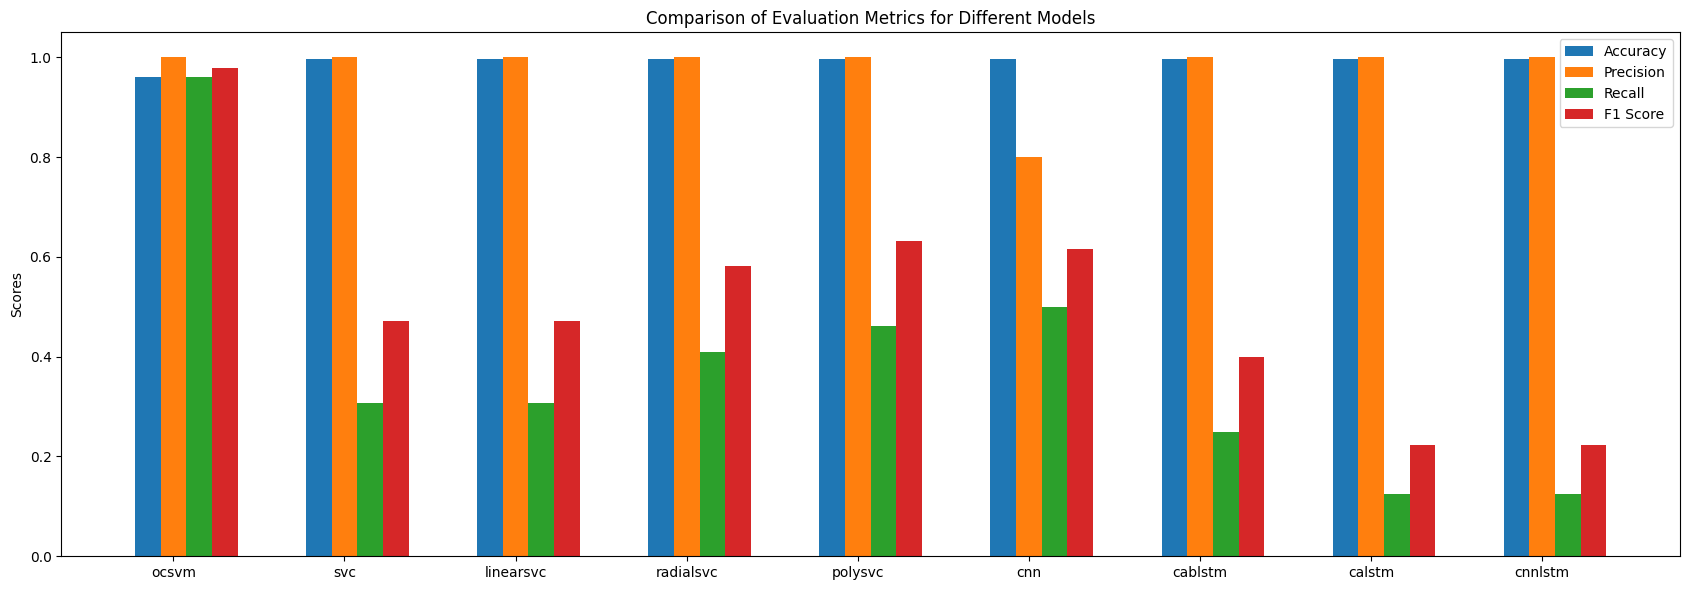

In [ ]:
evaluation_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

models = ['cnn', 'cablstm', 'calstm', 'cnnlstm']
accuracy_scores = [ accuracy_score(cnny_test, cnny_pred), accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred1), accuracy_score(y_test, y_pred2)]
precision_scores = [precision_score(cnny_test, cnny_pred), precision_score(y_test, y_pred),precision_score(y_test, y_pred1),precision_score(y_test, y_pred2)]
recall_scores = [recall_score(cnny_test, cnny_pred), recall_score(y_test, y_pred), recall_score(y_test, y_pred1), recall_score(y_test, y_pred2)]
f1_scores = [f1_score(cnny_test, cnny_pred), f1_score(y_test, y_pred),f1_score(y_test, y_pred1),f1_score(y_test, y_pred2)]
'''
geometric_means = [gm_score_ocsvm, gm_score_svc, gm_score_linearsvc, gm_score_radialsvc, gm_score_polysvc, gm_score_cnn, geo_mean(y_test_binary, y_pred_binary), geometric_mean_score(y_test_binary2, y_pred_binary2)]
geo_mean_alpha05 = [gm_alpha05_ocsvm, gm_alpha05_svc, gm_alpha05_linearsvc, gm_alpha05_radialsvc, gm_alpha05_polysvc, gm_alpha05_cnn, gm_alpha05_cablstm, gm_alpha05_cablstm50]
'''
evaluation_metrics['Accuracy'] = accuracy_scores
evaluation_metrics['Precision'] = precision_scores
evaluation_metrics['Recall'] = recall_scores
evaluation_metrics['F1 Score'] = f1_scores
#evaluation_metrics['Geometric Mean'] = geometric_means
#evaluation_metrics['Geo Mean (Alpha=0.5)'] = geo_mean_alpha05

# 막대 그래프 그리기
x = np.arange(len(models))
width = 0.15

plt.figure(figsize=(17, 6))

for i, metric in enumerate(evaluation_metrics.keys()):
    plt.bar(x + (i-1)  * width, evaluation_metrics[metric], width, label=metric)

plt.xticks(x, models)
plt.ylabel('Scores')
plt.title('Comparison of Evaluation Metrics for Different Models')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

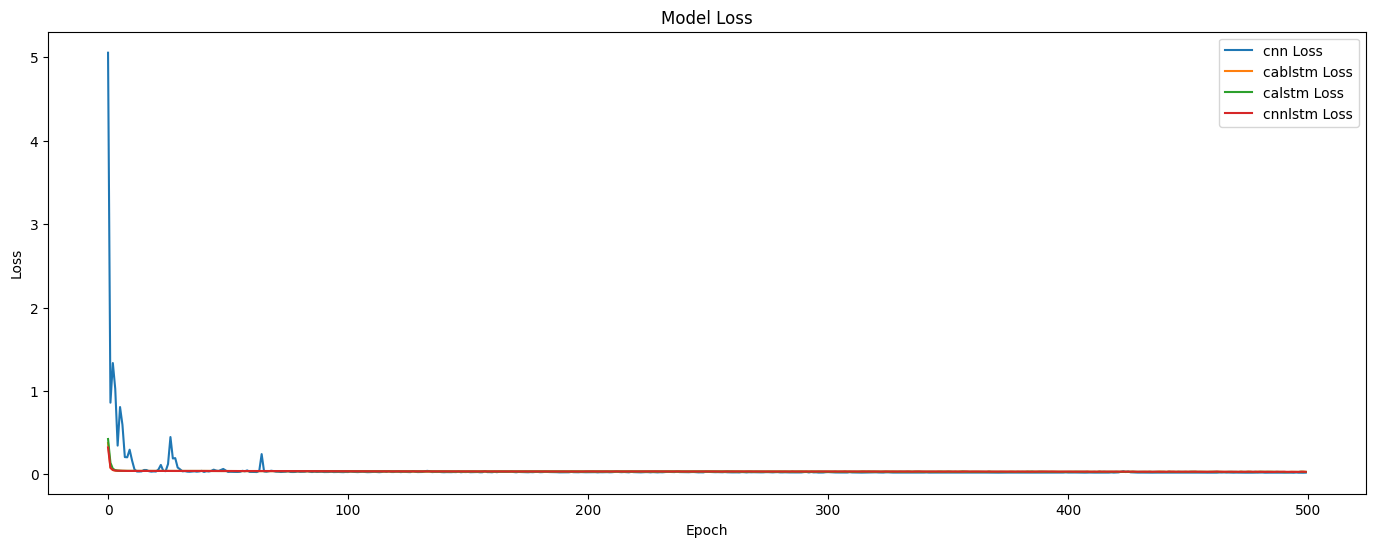

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(cnnhist.history['loss'], label='cnn Loss')
plt.plot(hist.history['loss'], label='cablstm Loss')
plt.plot(hist1.history['loss'], label='calstm Loss')
plt.plot(hist2.history['loss'], label='cnnlstm Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

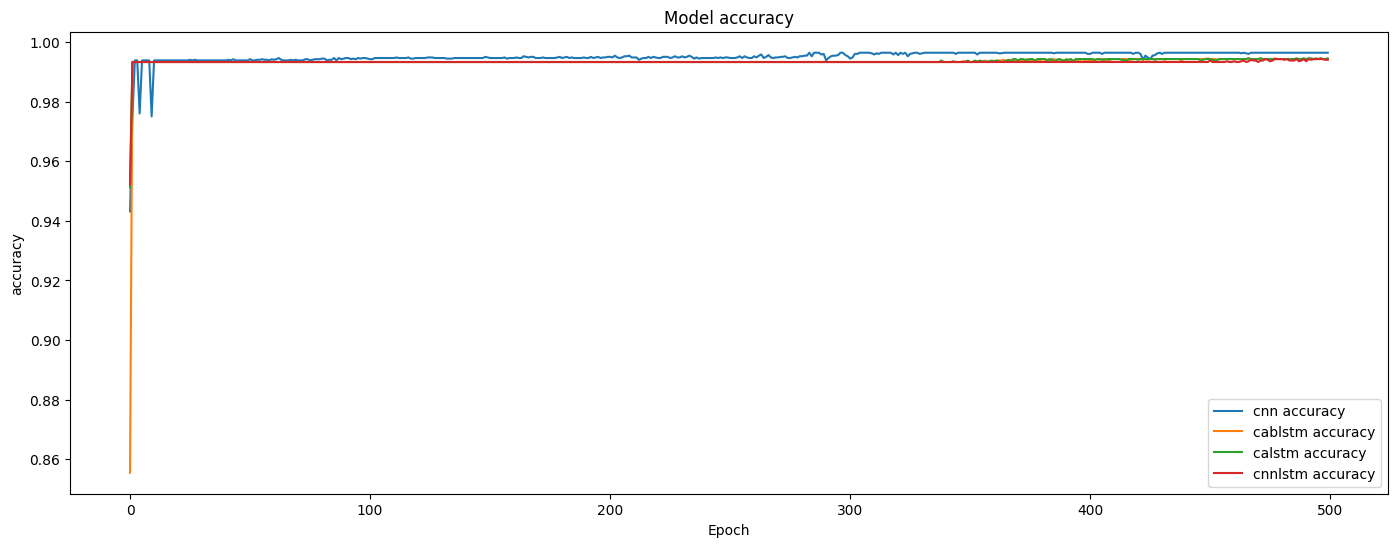

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(cnnhist.history['accuracy'], label='cnn accuracy')
plt.plot(hist.history['accuracy'], label='cablstm accuracy')
plt.plot(hist1.history['accuracy'], label='calstm accuracy')
plt.plot(hist2.history['accuracy'], label='cnnlstm accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

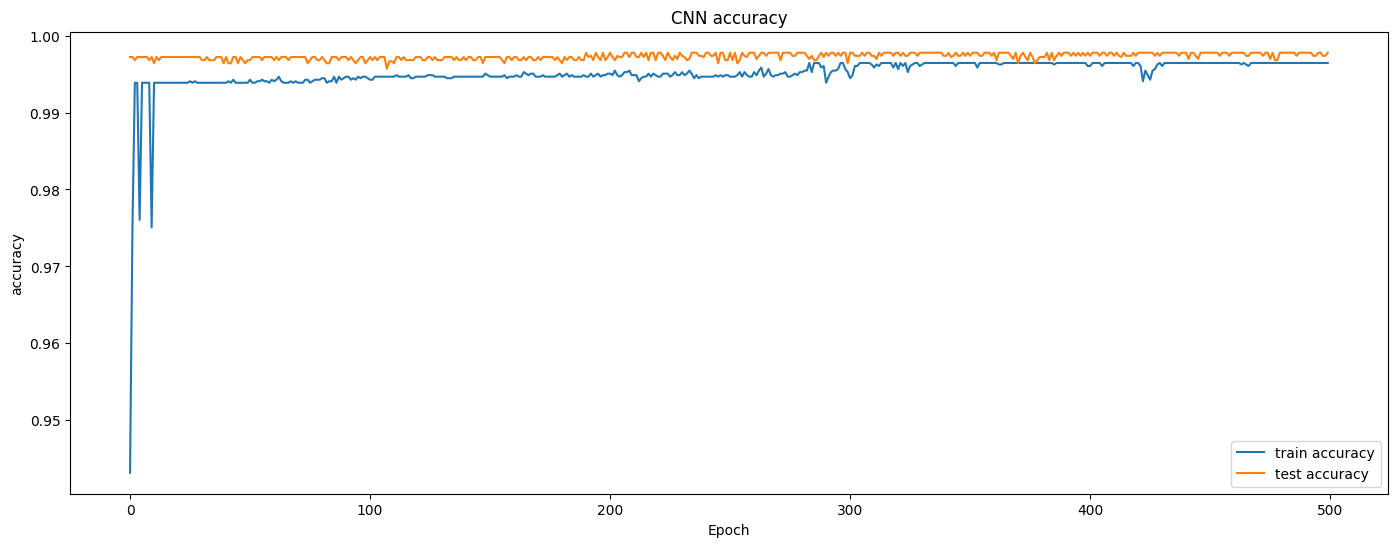

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(cnnhist.history['accuracy'], label='train accuracy')
plt.plot(cnntesthist.history['accuracy'], label='test accuracy')
plt.title('CNN accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

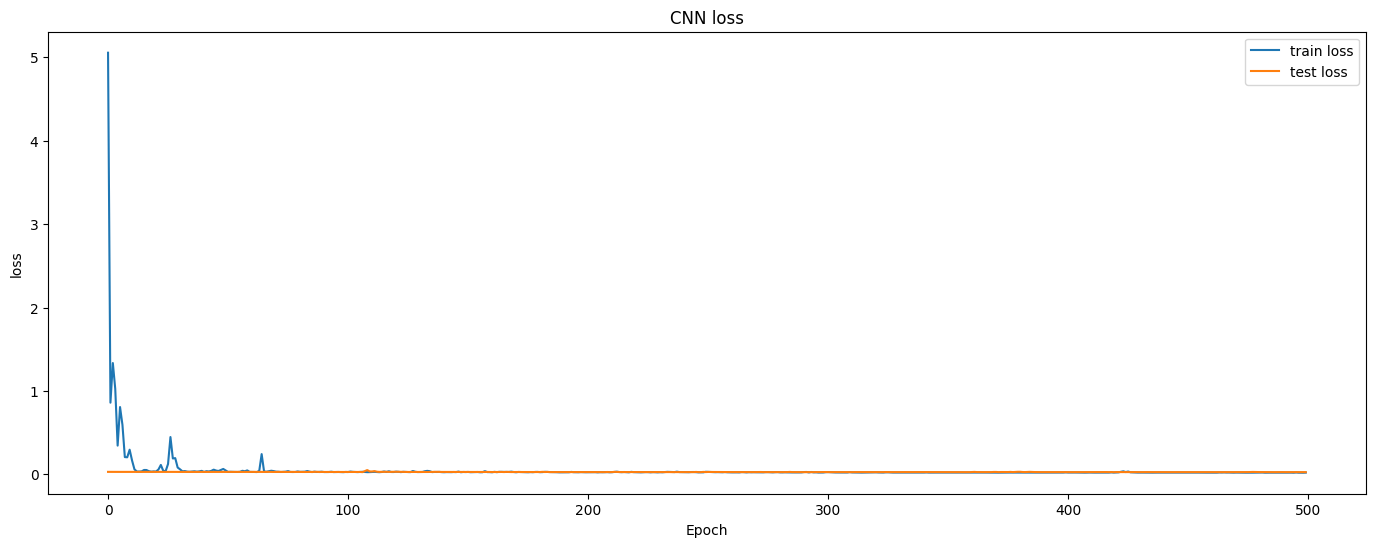

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(cnnhist.history['loss'], label='train loss')
plt.plot(cnntesthist.history['loss'], label='test loss')
plt.title('CNN loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

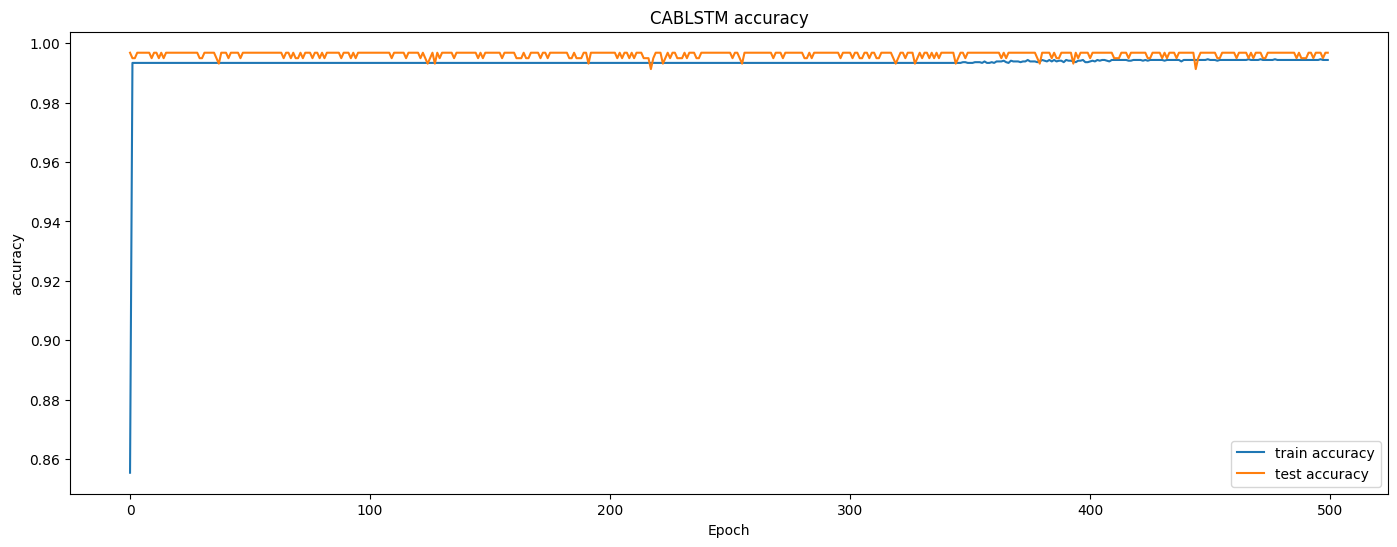

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(testhist.history['accuracy'], label='test accuracy')
plt.title('CABLSTM accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

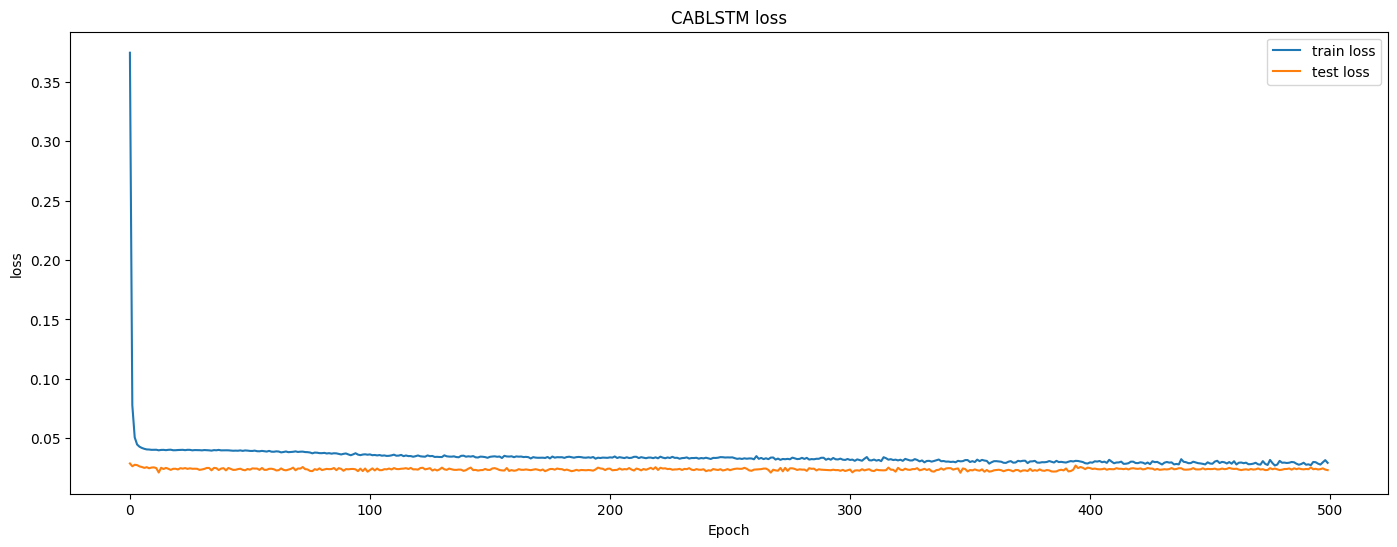

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist.history['loss'], label='train loss')
plt.plot(testhist.history['loss'], label='test loss')
plt.title('CABLSTM loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

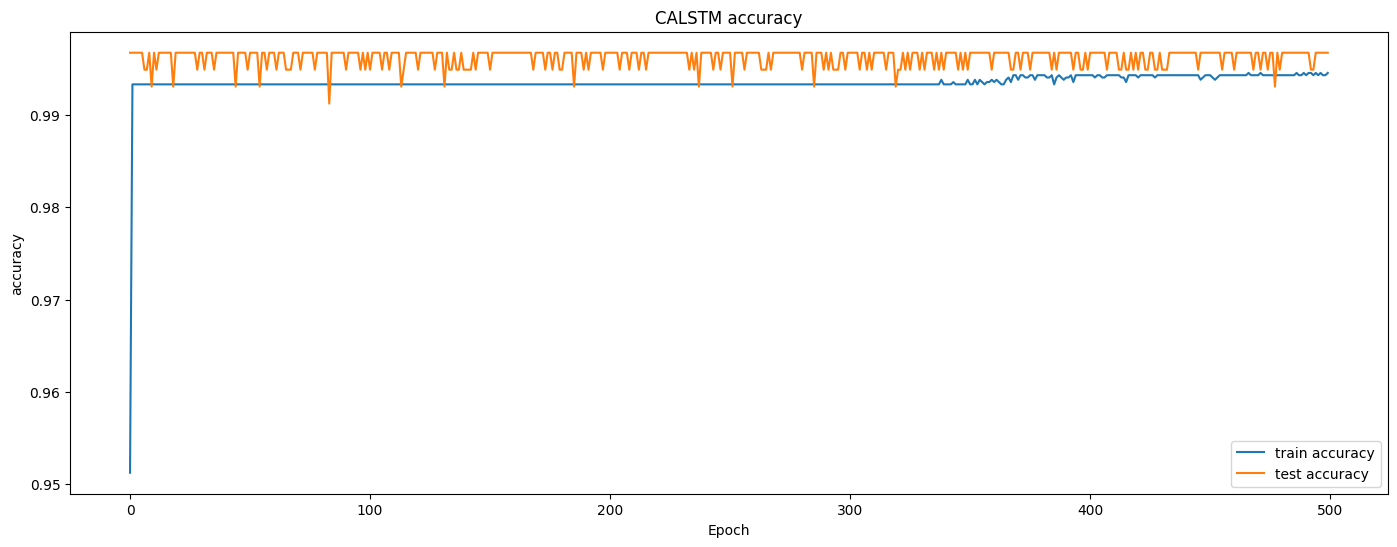

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist1.history['accuracy'], label='train accuracy')
plt.plot(testhist1.history['accuracy'], label='test accuracy')
plt.title('CALSTM accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

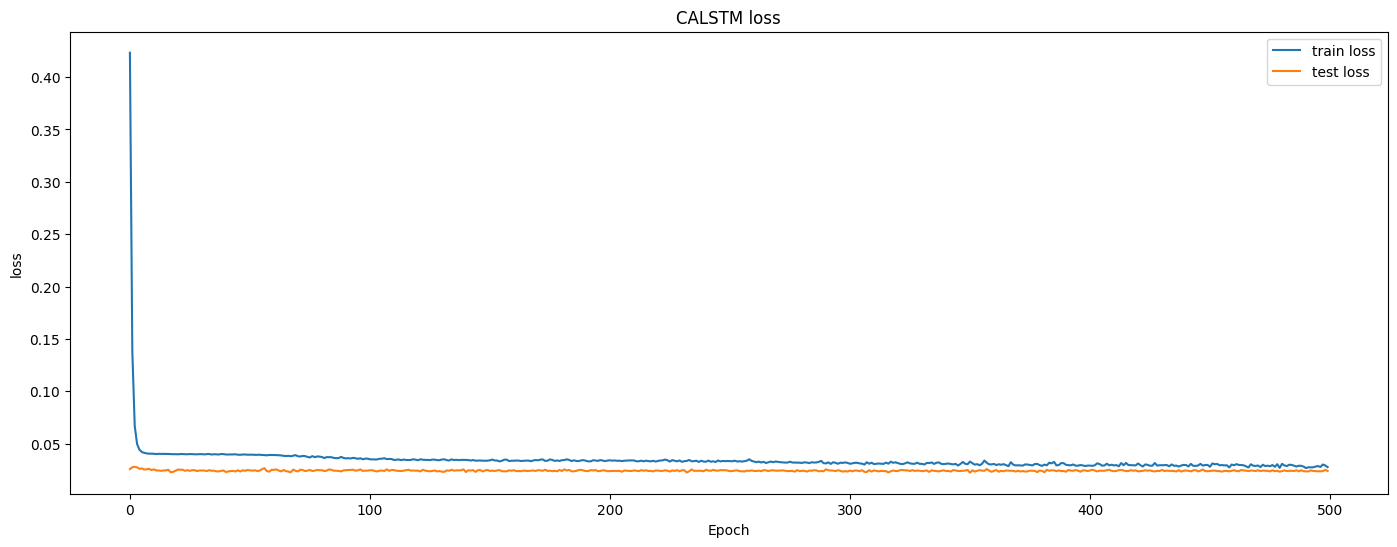

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist1.history['loss'], label='train loss')
plt.plot(testhist1.history['loss'], label='test loss')
plt.title('CALSTM loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

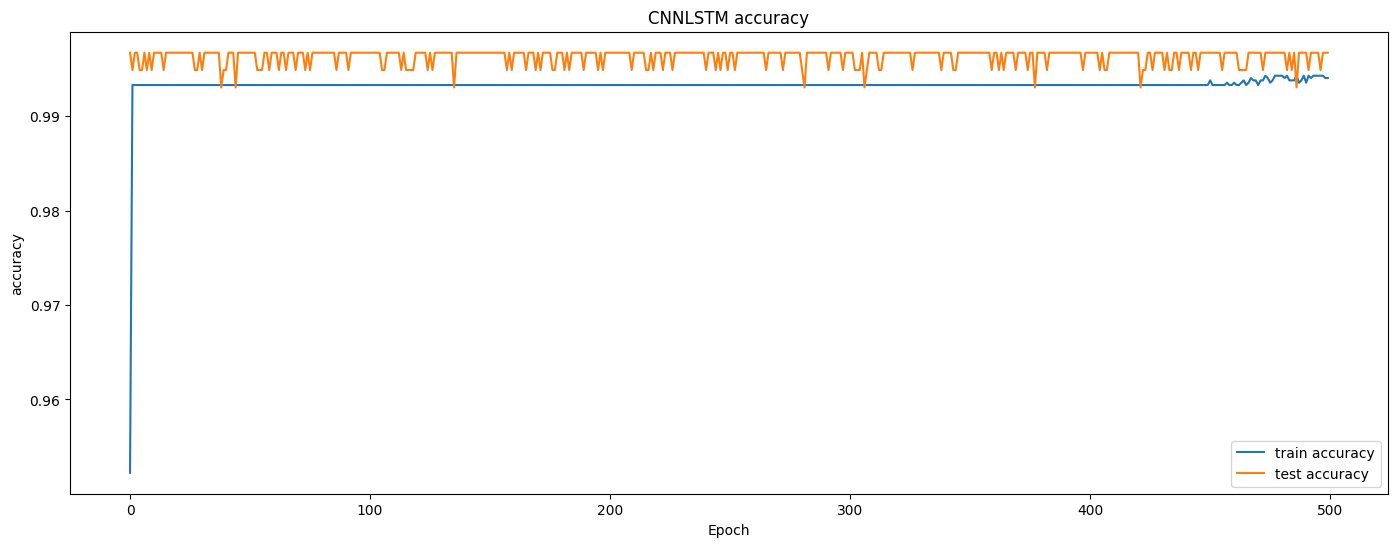

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist2.history['accuracy'], label='train accuracy')
plt.plot(testhist2.history['accuracy'], label='test accuracy')
plt.title('CNNLSTM accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

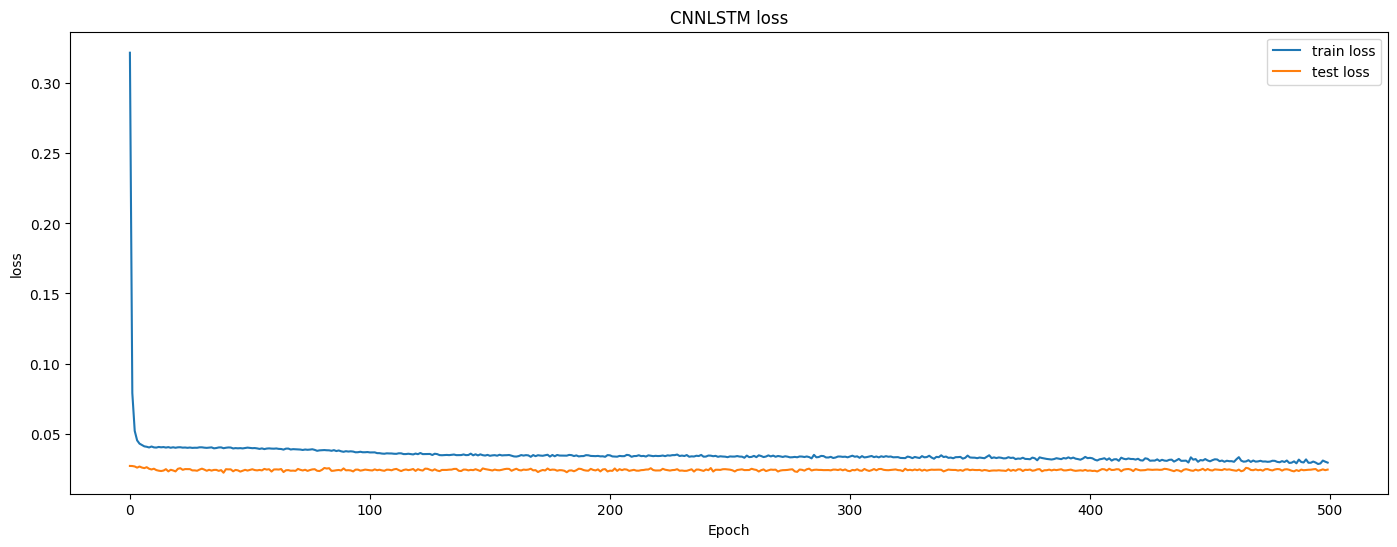

In [ ]:
plt.figure(figsize=(17, 6))

plt.plot(hist2.history['loss'], label='train loss')
plt.plot(testhist2.history['loss'], label='test loss')
plt.title('CNNLSTM loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 모델 저장

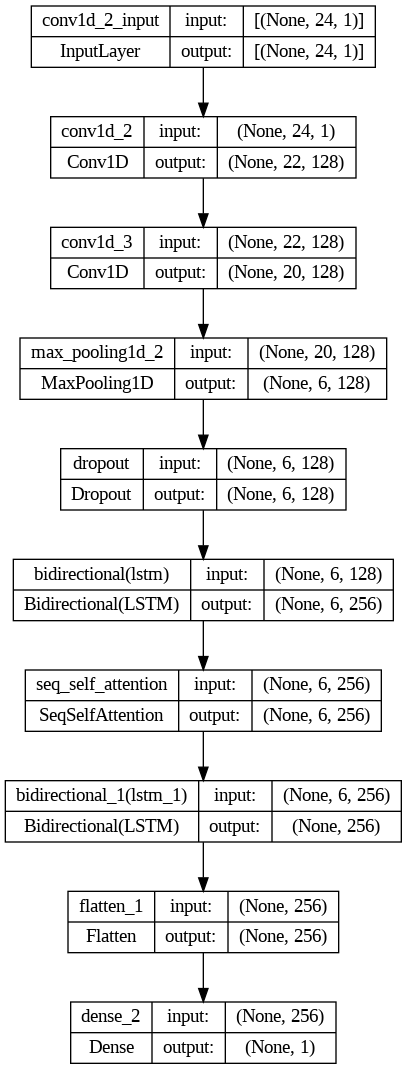

In [ ]:
from keras.utils import plot_model

plot_model(cablstm, to_file='cablstm.png', show_shapes=True)

## AUC 등 추가적 시각화

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_train shape:", y_train.shape)
print("x_test shape:", y_test.shape)

x_train shape: (5052, 24, 1)
x_test shape: (1684, 24, 1)
x_train shape: (5052,)
x_test shape: (1684,)


In [ ]:
auc_x_train = x_train.reshape(x_train.shape[0], -1)
auc_x_test = x_test.reshape(x_test.shape[0], -1)

print("x_train_flat shape:", auc_x_train.shape)
print("x_test_flat shape:", auc_x_test.shape)

x_train_flat shape: (5052, 24)
x_test_flat shape: (1684, 24)


In [ ]:
auc_cablstm = LogisticRegression()
auc_cablstm.fit(auc_x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
auc_y_prob = auc_cablstm.predict_proba(auc_x_test)[:, 1]

In [ ]:
auc_score = roc_auc_score(y_test, auc_y_prob)
print("CABLSTM AUC 면적:", auc_score)

CABLSTM AUC 면적: 0.8741050119331742


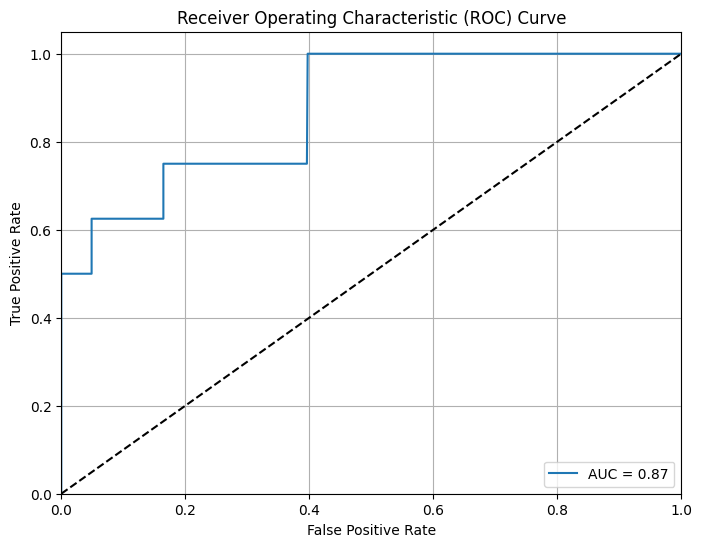

In [ ]:
fpr, tpr, _ = roc_curve(y_test, auc_y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

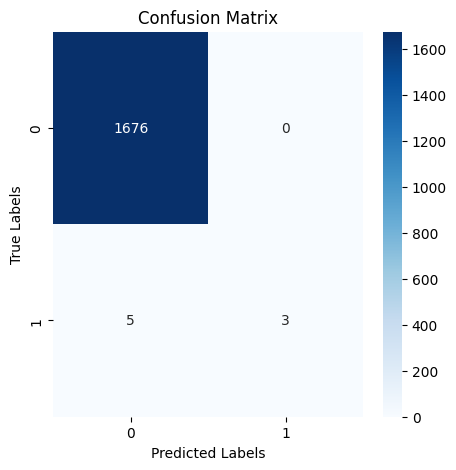

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = auc_cablstm.predict(auc_x_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

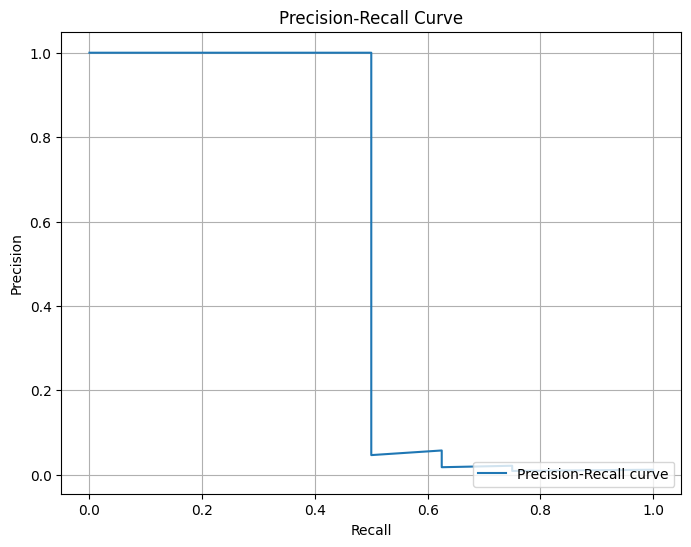

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, auc_y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1676
           1       1.00      0.38      0.55         8

    accuracy                           1.00      1684
   macro avg       1.00      0.69      0.77      1684
weighted avg       1.00      1.00      1.00      1684

